In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

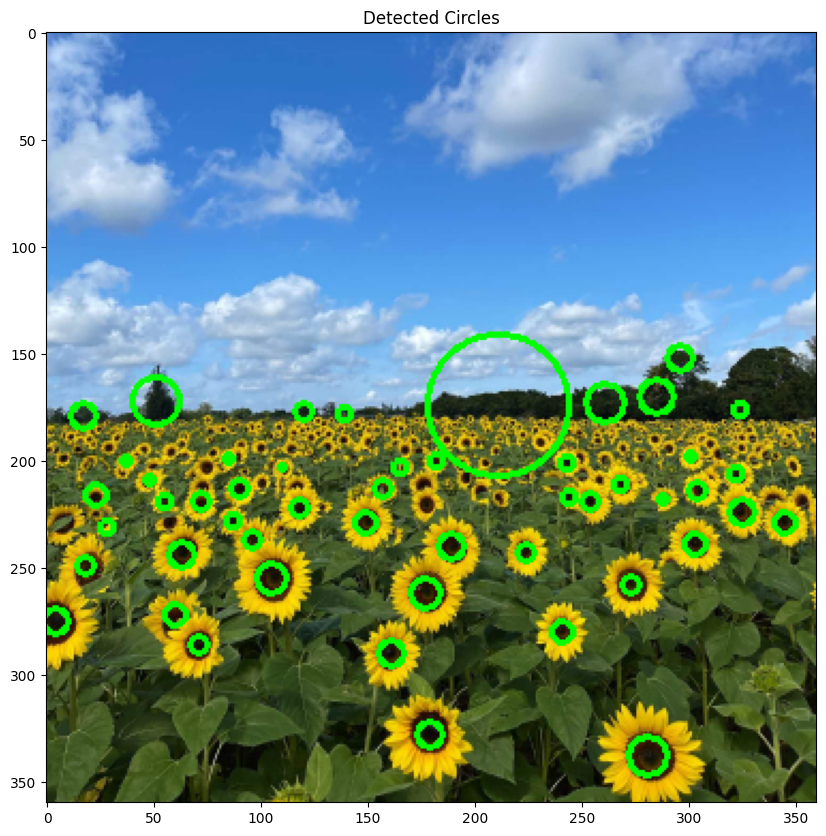

Circle center: (211, 174), radius: 33
Circle center: (177, 262), radius: 7
Circle center: (281, 338), radius: 9
Circle center: (161, 290), radius: 6
Circle center: (105, 255), radius: 7
Circle center: (303, 239), radius: 5
Circle center: (345, 229), radius: 5
Circle center: (261, 173), radius: 9
Circle center: (4, 275), radius: 6
Circle center: (149, 229), radius: 5
Circle center: (179, 328), radius: 6
Circle center: (325, 224), radius: 6
Circle center: (241, 280), radius: 5
Circle center: (296, 152), radius: 6
Circle center: (63, 244), radius: 6
Circle center: (51, 172), radius: 11
Circle center: (224, 243), radius: 4
Circle center: (273, 258), radius: 4
Circle center: (189, 240), radius: 6
Circle center: (268, 211), radius: 3
Circle center: (71, 286), radius: 4
Circle center: (118, 222), radius: 4
Circle center: (304, 214), radius: 4
Circle center: (60, 272), radius: 5
Circle center: (72, 219), radius: 4
Circle center: (254, 219), radius: 4
Circle center: (322, 206), radius: 3
Circle

In [61]:
# Step 1: Load and preprocess the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Step 2: Define a function for Laplacian of Gaussian (LoG)
def laplacian_of_gaussian(image, sigma):
    ksize = int(2 * (np.ceil(3 * sigma)) + 1)  # Kernel size is based on σ
    gaussian = cv.GaussianBlur(image, (ksize, ksize), sigma)
    log = cv.Laplacian(gaussian, cv.CV_64F)
    return log

# Step 3: Apply LoG across a range of scales (σ values)
sigmas = np.linspace(1, 30, 15)  # Example range for σ values

log_images = [laplacian_of_gaussian(gray, sigma) for sigma in sigmas]


# Step 4: Detect blobs by finding local extrema in the LoG responses
blobs = np.zeros_like(gray)
for log in log_images:
    # Local maxima detection can be done using a threshold
    thresholded = np.where(log > np.percentile(log, 99), log, 0)
    blobs = np.maximum(blobs, thresholded)

# Step 5: Find and draw the largest circles
# Simple blob detection (using contours) as a placeholder for finding circles
contours, _ = cv.findContours(blobs.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
largest_contours = sorted(contours, key=cv.contourArea, reverse=True)[:50]  # Get 5 largest blobs
# try:
#     largest_contours = sorted(contours, key=lambda cnt: cv.contourArea(cnt) / (cv.arcLength(cnt, True) ** 2), reverse=True)
# except ZeroDivisionError:
#     pass

# Draw the detected circles
output_image = im.copy()
for contour in largest_contours:
    (x, y), radius = cv.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)
    cv.circle(output_image, center, radius, (0, 255, 0), 2)  # Draw the circle

# Step 6: Show the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Detected Circles")
plt.show()

# Step 7: Report the largest circles
for contour in largest_contours:
    (x, y), radius = cv.minEnclosingCircle(contour)
    print(f"Circle center: ({int(x)}, {int(y)}), radius: {int(radius)}")

# Report the range of sigma values used
print(f"Range of σ values used: {sigmas}")


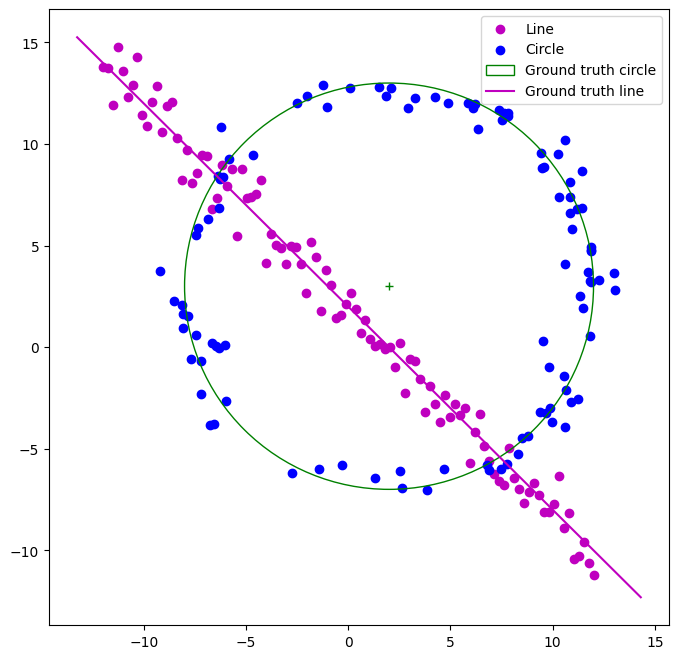

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Circle parameters
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of circle
half_n = 100  # Number of points for circle and line

# Noisy circle generation
s = r / 16  # Noise scaling factor
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Gaussian noise
x = x0_gt + (r + n) * np.cos(t)  # X-coordinates of noisy circle
y = y0_gt + (r + n) * np.sin(t)  # Y-coordinates of noisy circle
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Line parameters
s = 1.  # Noise scaling factor for line
m, b = -1, 2  # Slope and intercept of the line
x = np.linspace(-12, 12, half_n)  # X-coordinates for line
y = m * x + b + s * np.random.randn(half_n)  # Noisy Y-coordinates for line
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Combine both sets of points
X = np.vstack((X_circ, X_line))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line', color='m')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle', color='b')

# Plot ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Plot ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

# Finalize plot
plt.legend()
plt.show()

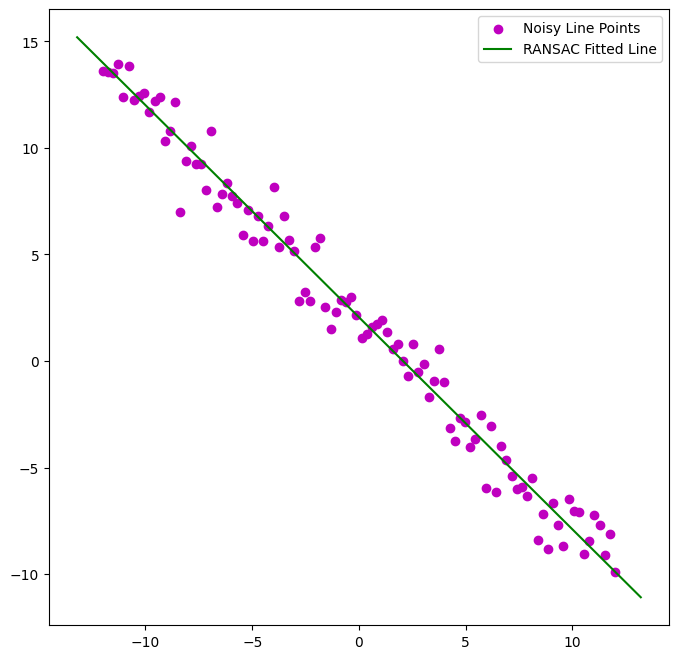

Best line found by RANSAC: a=0.7056044636190644, b=0.7086059136931138, d=-1.4545978810876246
Number of inliers: 56


In [64]:
import numpy as np
import random

def normalize_line_params(a, b, d):
    norm = np.sqrt(a**2 + b**2)
    return a / norm, b / norm, d / norm

def compute_line_through_points(p1, p2):
    """Compute the line parameters [a, b, d] from two points p1 and p2."""
    a = p2[1] - p1[1]  # (y2 - y1)
    b = p1[0] - p2[0]  # -(x2 - x1)
    d = -(a * p1[0] + b * p1[1])
    return normalize_line_params(a, b, d)

def point_to_line_distance(point, a, b, d):
    x, y = point
    return abs(a * x + b * y + d)

def ransac_line_fitting(points, num_iterations=2000, distance_threshold=0.5, consensus_threshold=0.5):
    best_line = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 2 points
        p1, p2 = points[random.sample(range(n_points), 2)]
        
        # Estimate the line [a, b, d] using the selected points
        a, b, d = compute_line_through_points(p1, p2)
        
        # Count inliers: points whose distance to the line is less than the threshold
        inliers = []
        for point in points:
            if point_to_line_distance(point, a, b, d) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)

        # Update the best model if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_line = (a, b, d)
    
    return best_line, best_inlier_count

# Example usage with generated points
import matplotlib.pyplot as plt

# Generate some random line points with noise (from previous example)
half_n = 100
s = 1.  # Noise scaling factor for line
m, b = -1, 2  # Slope and intercept of the line
x = np.linspace(-12, 12, half_n)  # X-coordinates for line
y = m * x + b + s * np.random.randn(half_n)  # Noisy Y-coordinates for line
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Run RANSAC line fitting with updated parameters
ransac_line, inlier_count = ransac_line_fitting(X_line, num_iterations=2000, distance_threshold=0.5, consensus_threshold=0.5)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Noisy Line Points', color='m')

# Plot the best line found by RANSAC
if ransac_line:
    a, b, d = ransac_line
    x_vals = np.array(ax.get_xlim())
    y_vals = -(a * x_vals + d) / b
    ax.plot(x_vals, y_vals, label='RANSAC Fitted Line', color='g')

plt.legend()
plt.show()

# Print the results
if ransac_line:
    print(f"Best line found by RANSAC: a={ransac_line[0]}, b={ransac_line[1]}, d={ransac_line[2]}")
    print(f"Number of inliers: {inlier_count}")
else:
    print("No line found with sufficient inliers.")


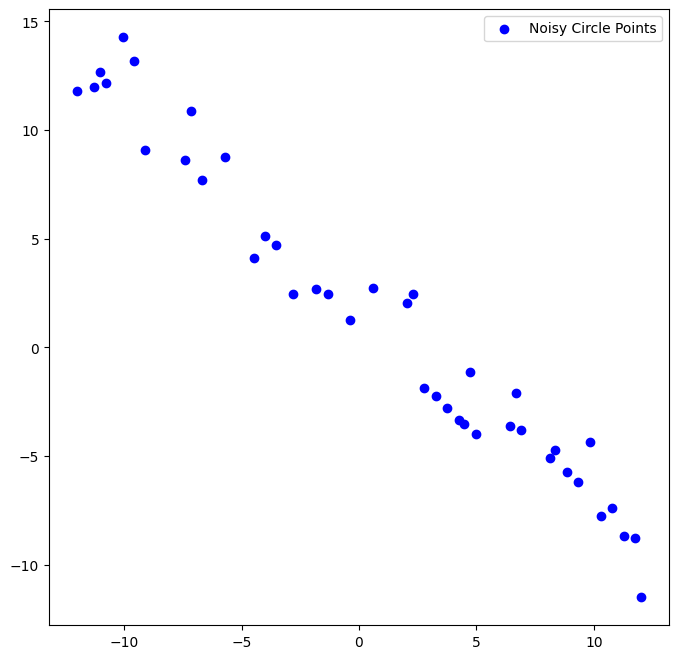

No circle found with sufficient inliers.


In [68]:
import numpy as np
import random
import matplotlib.pyplot as plt

def fit_circle_through_points(p1, p2, p3):
    """Fit a circle through three points."""
    A = np.array([p1, p2, p3])
    # Calculate midpoints of two line segments
    midpoint1 = (p1 + p2) / 2
    midpoint2 = (p2 + p3) / 2
    
    # Find the perpendicular bisectors of these two line segments
    v1 = np.array([-(p2[1] - p1[1]), p2[0] - p1[0]])
    v2 = np.array([-(p3[1] - p2[1]), p3[0] - p2[0]])
    
    # Solve the system of equations for the intersection of the two bisectors (circle center)
    A = np.vstack([v1, v2])
    b = np.vstack([midpoint1 @ v1, midpoint2 @ v2])
    
    try:
        center = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, None
    
    # Calculate the radius as the distance from the center to one of the points
    radius = np.linalg.norm(p1 - center)
    
    return center.ravel(), radius

def point_to_circle_distance(point, center, radius):
    """Compute the radial distance of a point to a circle defined by center and radius."""
    return abs(np.linalg.norm(point - center) - radius)

def ransac_circle_fitting(points, num_iterations=1000, distance_threshold=0.5, consensus_threshold=0.5):
    best_circle = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 3 points
        p1, p2, p3 = points[random.sample(range(n_points), 3)]
        
        # Estimate the circle [center, radius] using the selected points
        center, radius = fit_circle_through_points(p1, p2, p3)
        
        if center is None or radius is None:
            continue
        
        # Count inliers: points whose radial distance to the circle is less than the threshold
        inliers = []
        for point in points:
            if point_to_circle_distance(point, center, radius) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)

        # Update the best model if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_circle = (center, radius)
    
    return best_circle, best_inlier_count

# Function to subtract line inliers and fit the circle
def remove_line_inliers(points, line_params, distance_threshold):
    """Remove points that are considered inliers to the fitted line."""
    a, b, d = line_params
    remnant_points = []
    for point in points:
        if point_to_line_distance(point, a, b, d) >= distance_threshold:
            remnant_points.append(point)
    return np.array(remnant_points)

# Example usage with generated points (from previous code)
# Circle parameters
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of circle
half_n = 100  # Number of points for circle and line

# Noisy circle generation
s = r / 16  # Noise scaling factor
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Gaussian noise
x = x0_gt + (r + n) * np.cos(t)  # X-coordinates of noisy circle
y = y0_gt + (r + n) * np.sin(t)  # Y-coordinates of noisy circle
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Line parameters
s = 1.  # Noise scaling factor for line
m, b = -1, 2  # Slope and intercept of the line
x = np.linspace(-12, 12, half_n)  # X-coordinates for line
y = m * x + b + s * np.random.randn(half_n)  # Noisy Y-coordinates for line
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Combine both sets of points
X = np.vstack((X_circ, X_line))

# After running RANSAC to fit the line, subtract the inliers
ransac_line, inlier_count = ransac_line_fitting(X_line, num_iterations=2000, distance_threshold=0.5, consensus_threshold=0.5)

# Remove line inliers from the dataset
if ransac_line:
    X_remnant = remove_line_inliers(X_line, ransac_line, distance_threshold=0.5)
else:
    X_remnant = X_line  # If no line was found, just use the original points

# Now fit the circle to the remaining points using RANSAC with higher distance threshold and lower consensus
ransac_circle, circle_inlier_count = ransac_circle_fitting(
    X_remnant, 
    num_iterations=3000,  # Increase iterations
    distance_threshold=0.8,  # Increase distance threshold
    consensus_threshold=0.3  # Lower consensus threshold
)

# Plot the results as before
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_remnant[:, 0], X_remnant[:, 1], label='Noisy Circle Points', color='b')

# Plot the best circle found by RANSAC
if ransac_circle:
    center, radius = ransac_circle
    circle_plot = plt.Circle(center, radius, color='r', fill=False, label='RANSAC Fitted Circle')
    ax.add_artist(circle_plot)
    ax.scatter(*center, color='r', label='Circle Center')

plt.legend()
plt.show()

# Print the results
if ransac_circle:
    print(f"Best circle found by RANSAC: center={ransac_circle[0]}, radius={ransac_circle[1]}")
    print(f"Number of inliers: {circle_inlier_count}")
else:
    print("No circle found with sufficient inliers.")



Number of points left after removing line inliers: 98
Test circle center: [10. -0.], radius: 14.142135623730951


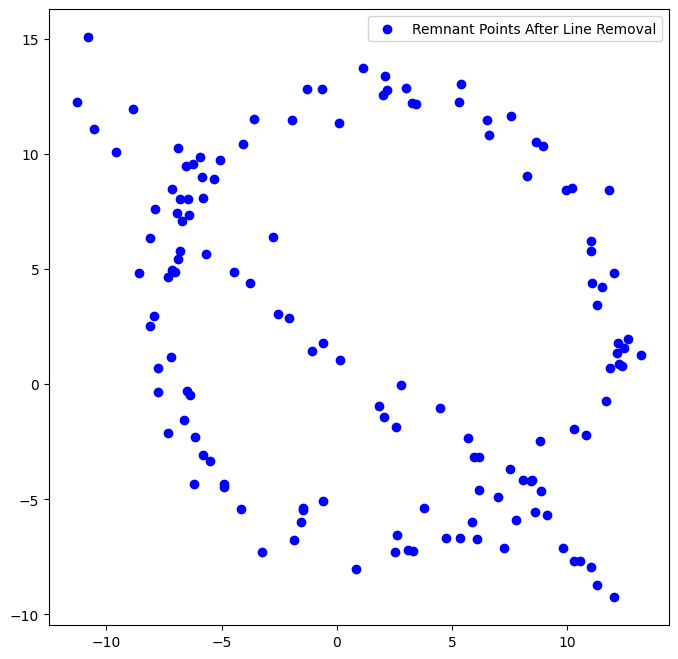

No circle found with sufficient inliers.


In [71]:
import numpy as np
import random
import matplotlib.pyplot as plt

def fit_circle_through_points(p1, p2, p3):
    """Fit a circle through three points, with additional checks for edge cases."""
    A = np.array([p1, p2, p3])
    
    # Check if the points are too close or nearly collinear
    if np.linalg.norm(p1 - p2) < 1e-6 or np.linalg.norm(p2 - p3) < 1e-6 or np.linalg.norm(p1 - p3) < 1e-6:
        return None, None
    
    # Calculate midpoints of two line segments
    midpoint1 = (p1 + p2) / 2
    midpoint2 = (p2 + p3) / 2
    
    # Find the perpendicular bisectors of these two line segments
    v1 = np.array([-(p2[1] - p1[1]), p2[0] - p1[0]])
    v2 = np.array([-(p3[1] - p2[1]), p3[0] - p2[0]])
    
    # Solve the system of equations for the intersection of the two bisectors (circle center)
    A = np.vstack([v1, v2])
    b = np.vstack([midpoint1 @ v1, midpoint2 @ v2])
    
    try:
        center = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, None
    
    # Calculate the radius as the distance from the center to one of the points
    radius = np.linalg.norm(p1 - center)
    
    return center.ravel(), radius

def point_to_circle_distance(point, center, radius):
    """Compute the radial distance of a point to a circle defined by center and radius."""
    return abs(np.linalg.norm(point - center) - radius)

def ransac_circle_fitting(points, num_iterations=1000, distance_threshold=0.5, consensus_threshold=0.5):
    best_circle = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 3 points
        p1, p2, p3 = points[random.sample(range(n_points), 3)]
        
        # Estimate the circle [center, radius] using the selected points
        center, radius = fit_circle_through_points(p1, p2, p3)
        
        if center is None or radius is None:
            continue
        
        # Count inliers: points whose radial distance to the circle is less than the threshold
        inliers = []
        for point in points:
            if point_to_circle_distance(point, center, radius) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)

        # Update the best model if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_circle = (center, radius)
    
    return best_circle, best_inlier_count

def point_to_line_distance(point, a, b, d):
    """Compute the normal distance of a point to a line defined by ax + by + d = 0."""
    return abs(a * point[0] + b * point[1] + d) / np.sqrt(a**2 + b**2)

def ransac_line_fitting(points, num_iterations=1000, distance_threshold=0.5, consensus_threshold=0.5):
    best_line = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 2 points to define a line
        p1, p2 = points[random.sample(range(n_points), 2)]
        
        # Line parameters (ax + by + d = 0)
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        d = -(a * p1[0] + b * p1[1])
        
        # Normalize [a, b] so that the unit vector condition holds: ||[a, b]|| = 1
        norm_factor = np.sqrt(a**2 + b**2)
        a /= norm_factor
        b /= norm_factor
        d /= norm_factor
        
        # Count inliers
        inliers = []
        for point in points:
            if point_to_line_distance(point, a, b, d) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)
        
        # Update the best line if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_line = (a, b, d)
    
    return best_line, best_inlier_count

def remove_line_inliers(points, line_params, distance_threshold):
    """Remove points that are considered inliers to the fitted line."""
    a, b, d = line_params
    remnant_points = []
    for point in points:
        if point_to_line_distance(point, a, b, d) >= distance_threshold:
            remnant_points.append(point)
    return np.array(remnant_points)

# Example usage with generated points
# Circle parameters
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of circle
half_n = 100  # Number of points for circle and line

# Noisy circle generation
s = r / 16  # Noise scaling factor
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Gaussian noise
x = x0_gt + (r + n) * np.cos(t)  # X-coordinates of noisy circle
y = y0_gt + (r + n) * np.sin(t)  # Y-coordinates of noisy circle
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Line parameters
s = 1.  # Noise scaling factor for line
m, b = -1, 2  # Slope and intercept of the line
x = np.linspace(-12, 12, half_n)  # X-coordinates for line
y = m * x + b + s * np.random.randn(half_n)  # Noisy Y-coordinates for line
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Apply RANSAC to fit the line
ransac_line, inlier_count = ransac_line_fitting(X_line, num_iterations=2000, distance_threshold=0.5, consensus_threshold=0.5)

# Remove line inliers from the dataset
if ransac_line:
    X_remnant = remove_line_inliers(X_circ, ransac_line, distance_threshold=0.5)
    print(f"Number of points left after removing line inliers: {len(X_remnant)}")
else:
    X_remnant = X_line  # If no line was found, just use the original points
    print("No line found, using all points.")

# X = np.vstack((X_circ, X_remnant))

# Test circle fitting function on known points (optional)
p1 = np.array([0, 10])
p2 = np.array([10, 0])
p3 = np.array([-10, 0])
center, radius = fit_circle_through_points(p1, p2, p3)
print(f"Test circle center: {center}, radius: {radius}")

# Now fit the circle to the remaining points using RANSAC
ransac_circle, circle_inlier_count = ransac_circle_fitting(X_circ, num_iterations=2000, distance_threshold=0.8, consensus_threshold=0.3)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Remnant Points After Line Removal', color='b')

# Plot the best circle found by RANSAC
if ransac_circle:
    center, radius = ransac_circle
    circle_plot = plt.Circle(center, radius, color='r', fill=False, label='RANSAC Fitted Circle')
    ax.add_artist(circle_plot)
    ax.scatter(*center, color='r', label='Circle Center')

plt.legend()
plt.show()

# Print the results
if ransac_circle:
    print(f"Best circle found by RANSAC: center={ransac_circle[0]}, radius={ransac_circle[1]}")
    print(f"Number of inliers: {circle_inlier_count}")
else:
    print("No circle found with sufficient inliers.")


Number of points left after removing line inliers: 98


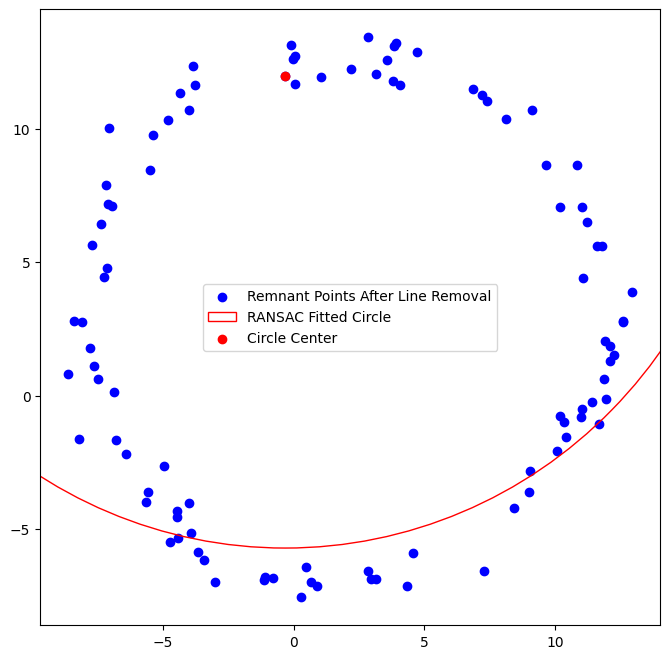

Best circle found by RANSAC: center=[-0.31914658 11.95301645], radius=17.66274479692205
Number of inliers: 36


In [82]:
import numpy as np
import random
import matplotlib.pyplot as plt

def fit_circle_through_points(p1, p2, p3):
    """Fit a circle through three points."""
    A = np.array([p1, p2, p3])
    
    # Check if the points are too close or nearly collinear
    if np.linalg.norm(p1 - p2) < 1e-6 or np.linalg.norm(p2 - p3) < 1e-6 or np.linalg.norm(p1 - p3) < 1e-6:
        return None, None
    
    # Calculate midpoints of two line segments
    midpoint1 = (p1 + p2) / 2
    midpoint2 = (p2 + p3) / 2
    
    # Find the perpendicular bisectors of these two line segments
    v1 = np.array([-(p2[1] - p1[1]), p2[0] - p1[0]])
    v2 = np.array([-(p3[1] - p2[1]), p3[0] - p2[0]])
    
    # Solve the system of equations for the intersection of the two bisectors (circle center)
    A = np.vstack([v1, v2])
    b = np.vstack([midpoint1 @ v1, midpoint2 @ v2])
    
    try:
        center = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, None
    
    # Calculate the radius as the distance from the center to one of the points
    radius = np.linalg.norm(p1 - center)
    
    return center.ravel(), radius

def point_to_circle_distance(point, center, radius):
    """Compute the radial distance of a point to a circle defined by center and radius."""
    return abs(np.linalg.norm(point - center) - radius)

def ransac_circle_fitting(points, num_iterations=1000, distance_threshold=0.5, consensus_threshold=0.5):
    best_circle = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 3 points
        p1, p2, p3 = points[random.sample(range(n_points), 3)]
        
        # Estimate the circle [center, radius] using the selected points
        center, radius = fit_circle_through_points(p1, p2, p3)
        
        if center is None or radius is None:
            continue
        
        # Count inliers: points whose radial distance to the circle is less than the threshold
        inliers = []
        for point in points:
            if point_to_circle_distance(point, center, radius) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)

        # Update the best model if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_circle = (center, radius)
    
    return best_circle, best_inlier_count

def point_to_line_distance(point, a, b, d):
    """Compute the normal distance of a point to a line defined by ax + by + d = 0."""
    return abs(a * point[0] + b * point[1] + d) / np.sqrt(a**2 + b**2)

def ransac_line_fitting(points, num_iterations=1000, distance_threshold=0.5, consensus_threshold=0.5):
    best_line = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 2 points to define a line
        p1, p2 = points[random.sample(range(n_points), 2)]
        
        # Line parameters (ax + by + d = 0)
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        d = -(a * p1[0] + b * p1[1])
        
        # Normalize [a, b] so that the unit vector condition holds: ||[a, b]|| = 1
        norm_factor = np.sqrt(a**2 + b**2)
        a /= norm_factor
        b /= norm_factor
        d /= norm_factor
        
        # Count inliers
        inliers = []
        for point in points:
            if point_to_line_distance(point, a, b, d) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)
        
        # Update the best line if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_line = (a, b, d)
    
    return best_line, best_inlier_count

def remove_line_inliers(points, line_params, distance_threshold):
    """Remove points that are considered inliers to the fitted line."""
    a, b, d = line_params
    remnant_points = []
    for point in points:
        if point_to_line_distance(point, a, b, d) >= distance_threshold:
            remnant_points.append(point)
    return np.array(remnant_points)

# Example usage with generated points
# Circle parameters
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of circle
half_n = 100  # Number of points for circle and line

# Noisy circle generation
s = r / 16  # Noise scaling factor
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Gaussian noise
x = x0_gt + (r + n) * np.cos(t)  # X-coordinates of noisy circle
y = y0_gt + (r + n) * np.sin(t)  # Y-coordinates of noisy circle
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Line parameters
s = 1.  # Noise scaling factor for line
m, b = -1, 2  # Slope and intercept of the line
x = np.linspace(-12, 12, half_n)  # X-coordinates for line
y = m * x + b + s * np.random.randn(half_n)  # Noisy Y-coordinates for line
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Combine both sets of points
X = np.vstack((X_circ, X_line))

# Apply RANSAC to fit the line
ransac_line, inlier_count = ransac_line_fitting(X_line, num_iterations=2000, distance_threshold=0.5, consensus_threshold=0.5)

# Remove line inliers from the combined dataset
if ransac_line:
    X_remnant = remove_line_inliers(X_circ, ransac_line, distance_threshold=0.5)
    print(f"Number of points left after removing line inliers: {len(X_remnant)}")
else:
    X_remnant = X  # If no line was found, just use the original points
    print("No line found, using all points.")

# Now fit the circle to the remaining points using RANSAC
ransac_circle, circle_inlier_count = ransac_circle_fitting(X_remnant, num_iterations=3000, distance_threshold=1.5, consensus_threshold=0.2)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_remnant[:, 0], X_remnant[:, 1], label='Remnant Points After Line Removal', color='b')

# Plot the best circle found by RANSAC
if ransac_circle:
    center, radius = ransac_circle
    circle_plot = plt.Circle(center, radius, color='r', fill=False, label='RANSAC Fitted Circle')
    ax.add_artist(circle_plot)
    ax.scatter(*center, color='r', label='Circle Center')

plt.legend()
plt.show()

# Print the results
if ransac_circle:
    print(f"Best circle found by RANSAC: center={ransac_circle[0]}, radius={ransac_circle[1]}")
    print(f"Number of inliers: {circle_inlier_count}")
else:
    print("No circle found with sufficient inliers.")


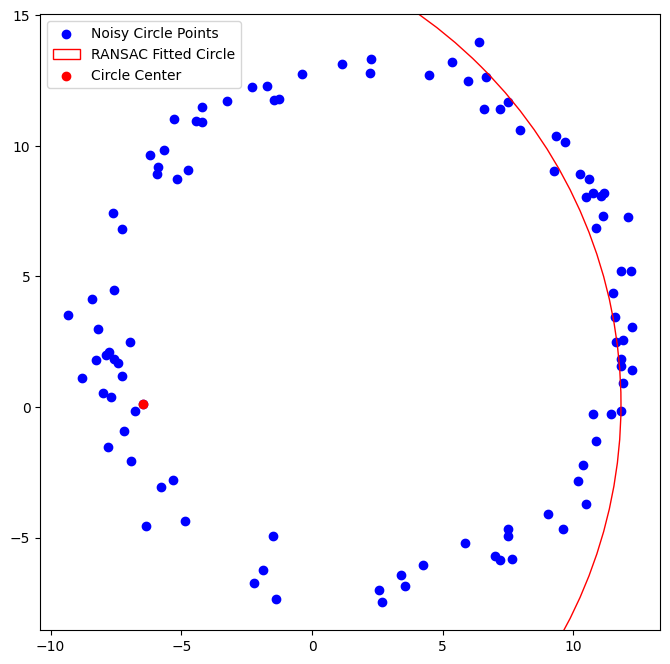

Best circle found by RANSAC: center=[-6.44704392  0.10937277], radius=18.264906423085794
Number of inliers: 37


In [83]:
import numpy as np
import random
import matplotlib.pyplot as plt

def fit_circle_through_points(p1, p2, p3):
    """Fit a circle through three points."""
    # Check if the points are too close or nearly collinear
    if np.linalg.norm(p1 - p2) < 1e-6 or np.linalg.norm(p2 - p3) < 1e-6 or np.linalg.norm(p1 - p3) < 1e-6:
        return None, None
    
    # Midpoints of line segments
    midpoint1 = (p1 + p2) / 2
    midpoint2 = (p2 + p3) / 2
    
    # Vectors perpendicular to the line segments
    v1 = np.array([-(p2[1] - p1[1]), p2[0] - p1[0]])
    v2 = np.array([-(p3[1] - p2[1]), p3[0] - p2[0]])
    
    # Solve for the intersection of the two perpendicular bisectors
    A = np.vstack([v1, v2])
    b = np.vstack([midpoint1 @ v1, midpoint2 @ v2])
    
    try:
        center = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, None
    
    # Calculate radius
    radius = np.linalg.norm(p1 - center)
    
    return center.ravel(), radius

def point_to_circle_distance(point, center, radius):
    """Compute the radial distance of a point to a circle defined by center and radius."""
    return abs(np.linalg.norm(point - center) - radius)

def ransac_circle_fitting(points, num_iterations=2000, distance_threshold=1.0, consensus_threshold=0.5):
    best_circle = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 3 points
        p1, p2, p3 = points[random.sample(range(n_points), 3)]
        
        # Estimate the circle [center, radius]
        center, radius = fit_circle_through_points(p1, p2, p3)
        
        if center is None or radius is None:
            continue
        
        # Count inliers
        inliers = []
        for point in points:
            if point_to_circle_distance(point, center, radius) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)

        # Update the best model if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_circle = (center, radius)
    
    return best_circle, best_inlier_count

# Example usage with generated points
# Circle parameters
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of circle
half_n = 100  # Number of points for circle and line

# Noisy circle generation
s = r / 16  # Noise scaling factor
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Gaussian noise
x = x0_gt + (r + n) * np.cos(t)  # X-coordinates of noisy circle
y = y0_gt + (r + n) * np.sin(t)  # Y-coordinates of noisy circle
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Apply RANSAC to fit the circle
ransac_circle, circle_inlier_count = ransac_circle_fitting(X_circ, num_iterations=3000, distance_threshold=1.5, consensus_threshold=0.3)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Noisy Circle Points', color='b')

# Plot the best circle found by RANSAC
if ransac_circle:
    center, radius = ransac_circle
    circle_plot = plt.Circle(center, radius, color='r', fill=False, label='RANSAC Fitted Circle')
    ax.add_artist(circle_plot)
    ax.scatter(*center, color='r', label='Circle Center')

plt.legend()
plt.show()

# Print the results
if ransac_circle:
    print(f"Best circle found by RANSAC: center={ransac_circle[0]}, radius={ransac_circle[1]}")
    print(f"Number of inliers: {circle_inlier_count}")
else:
    print("No circle found with sufficient inliers.")



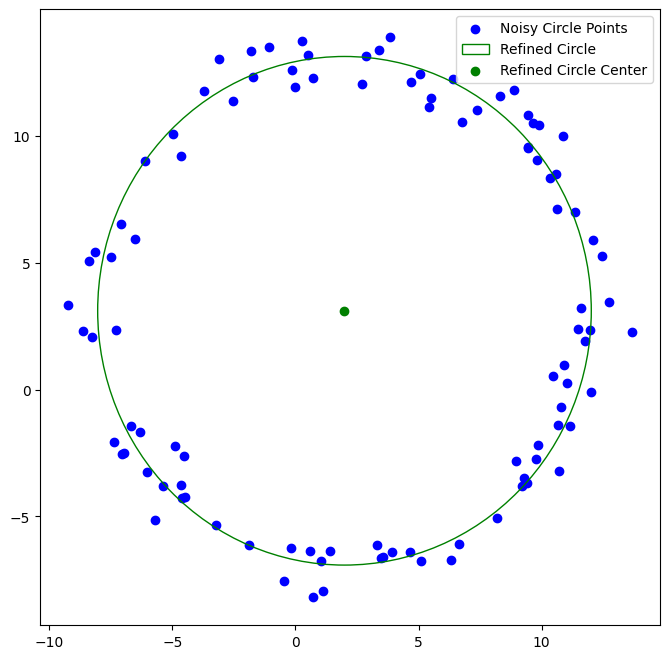

Refined circle found: center=[1.99308386 3.10884862], radius=10.025918984709445


In [84]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def fit_circle_through_points(p1, p2, p3):
    """Fit a circle through three points."""
    # Check if the points are too close or nearly collinear
    if np.linalg.norm(p1 - p2) < 1e-6 or np.linalg.norm(p2 - p3) < 1e-6 or np.linalg.norm(p1 - p3) < 1e-6:
        return None, None
    
    # Midpoints of line segments
    midpoint1 = (p1 + p2) / 2
    midpoint2 = (p2 + p3) / 2
    
    # Vectors perpendicular to the line segments
    v1 = np.array([-(p2[1] - p1[1]), p2[0] - p1[0]])
    v2 = np.array([-(p3[1] - p2[1]), p3[0] - p2[0]])
    
    # Solve for the intersection of the two perpendicular bisectors
    A = np.vstack([v1, v2])
    b = np.vstack([midpoint1 @ v1, midpoint2 @ v2])
    
    try:
        center = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, None
    
    # Calculate radius
    radius = np.linalg.norm(p1 - center)
    
    return center.ravel(), radius

def point_to_circle_distance(point, center, radius):
    """Compute the radial distance of a point to a circle defined by center and radius."""
    return abs(np.linalg.norm(point - center) - radius)

def ransac_circle_fitting(points, num_iterations=2000, distance_threshold=1.0, consensus_threshold=0.5):
    best_circle = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 3 points
        p1, p2, p3 = points[random.sample(range(n_points), 3)]
        
        # Estimate the circle [center, radius]
        center, radius = fit_circle_through_points(p1, p2, p3)
        
        if center is None or radius is None:
            continue
        
        # Count inliers
        inliers = []
        for point in points:
            if point_to_circle_distance(point, center, radius) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)

        # Update the best model if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_circle = (center, radius)
    
    return best_circle, best_inlier_count

def least_squares_circle_fitting(points, initial_center, initial_radius):
    """Refine the circle fitting using least squares optimization."""
    
    def residual(params):
        center = np.array([params[0], params[1]])
        radius = params[2]
        residuals = [np.linalg.norm(point - center) - radius for point in points]
        return np.sum(np.square(residuals))
    
    # Initial guess for center and radius
    initial_guess = np.array([*initial_center, initial_radius])
    
    # Minimize residuals
    result = minimize(residual, initial_guess, method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (1e-6, np.inf)])
    
    optimized_center = result.x[:2]
    optimized_radius = result.x[2]
    
    return optimized_center, optimized_radius

# Example usage with generated points
# Circle parameters
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of circle
half_n = 100  # Number of points for circle and line

# Noisy circle generation
s = r / 16  # Noise scaling factor
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Gaussian noise
x = x0_gt + (r + n) * np.cos(t)  # X-coordinates of noisy circle
y = y0_gt + (r + n) * np.sin(t)  # Y-coordinates of noisy circle
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array

# Apply RANSAC to fit the circle
ransac_circle, circle_inlier_count = ransac_circle_fitting(X_circ, num_iterations=3000, distance_threshold=1.5, consensus_threshold=0.3)

# Refine the circle fit with least squares
if ransac_circle:
    center, radius = ransac_circle
    refined_center, refined_radius = least_squares_circle_fitting(X_circ, center, radius)
else:
    refined_center, refined_radius = None, None

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Noisy Circle Points', color='b')

# Plot the best circle found by RANSAC and refined fit
if refined_center is not None:
    circle_plot = plt.Circle(refined_center, refined_radius, color='g', fill=False, label='Refined Circle')
    ax.add_artist(circle_plot)
    ax.scatter(*refined_center, color='g', label='Refined Circle Center')

plt.legend()
plt.show()

# Print the results
if refined_center is not None:
    print(f"Refined circle found: center={refined_center}, radius={refined_radius}")
else:
    print("No circle found with sufficient inliers.")


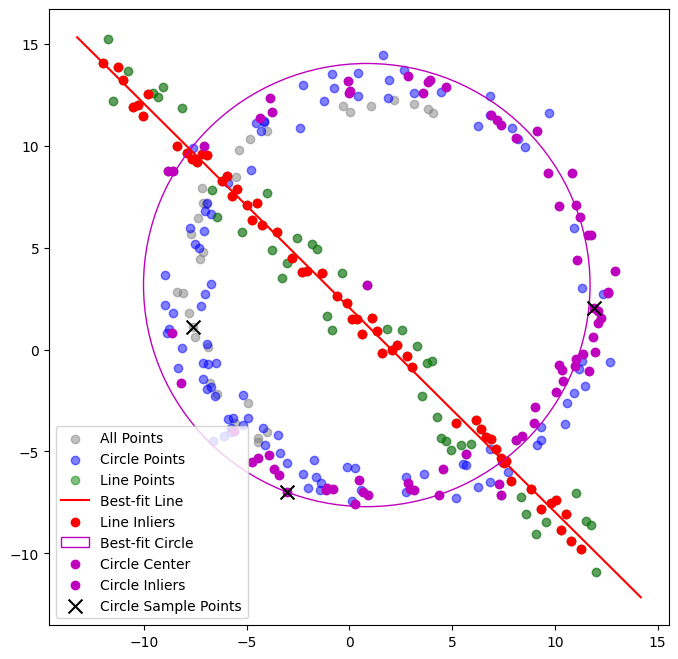

In [86]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Code for line fitting, circle fitting, and point removal is unchanged
def fit_circle_through_points(p1, p2, p3):
    """Fit a circle through three points."""
    # Check if the points are too close or nearly collinear
    if np.linalg.norm(p1 - p2) < 1e-6 or np.linalg.norm(p2 - p3) < 1e-6 or np.linalg.norm(p1 - p3) < 1e-6:
        return None, None
    
    # Midpoints of line segments
    midpoint1 = (p1 + p2) / 2
    midpoint2 = (p2 + p3) / 2
    
    # Vectors perpendicular to the line segments
    v1 = np.array([-(p2[1] - p1[1]), p2[0] - p1[0]])
    v2 = np.array([-(p3[1] - p2[1]), p3[0] - p2[0]])
    
    # Solve for the intersection of the two perpendicular bisectors
    A = np.vstack([v1, v2])
    b = np.vstack([midpoint1 @ v1, midpoint2 @ v2])
    
    try:
        center = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, None
    
    # Calculate radius
    radius = np.linalg.norm(p1 - center)
    
    return center.ravel(), radius

def point_to_circle_distance(point, center, radius):
    """Compute the radial distance of a point to a circle defined by center and radius."""
    return abs(np.linalg.norm(point - center) - radius)

def ransac_circle_fitting(points, num_iterations=2000, distance_threshold=1.0, consensus_threshold=0.5):
    best_circle = None
    best_inlier_count = 0
    n_points = points.shape[0]

    for _ in range(num_iterations):
        # Randomly select 3 points
        p1, p2, p3 = points[random.sample(range(n_points), 3)]
        
        # Estimate the circle [center, radius]
        center, radius = fit_circle_through_points(p1, p2, p3)
        
        if center is None or radius is None:
            continue
        
        # Count inliers
        inliers = []
        for point in points:
            if point_to_circle_distance(point, center, radius) < distance_threshold:
                inliers.append(point)
        
        inlier_count = len(inliers)

        # Update the best model if we have more inliers
        if inlier_count > best_inlier_count and inlier_count > consensus_threshold * n_points:
            best_inlier_count = inlier_count
            best_circle = (center, radius)
    
    return best_circle, best_inlier_count

def least_squares_circle_fitting(points, initial_center, initial_radius):
    """Refine the circle fitting using least squares optimization."""
    
    def residual(params):
        center = np.array([params[0], params[1]])
        radius = params[2]
        residuals = [np.linalg.norm(point - center) - radius for point in points]
        return np.sum(np.square(residuals))
    
    # Initial guess for center and radius
    initial_guess = np.array([*initial_center, initial_radius])
    
    # Minimize residuals
    result = minimize(residual, initial_guess, method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (1e-6, np.inf)])
    
    optimized_center = result.x[:2]
    optimized_radius = result.x[2]
    
    return optimized_center, optimized_radius

# Plot the point set, best-fit line, best-fit circle, and inliers
def plot_results(X, X_line, X_circle, line_model, line_inliers, circle_model, circle_inliers, circle_sample):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all points (circle + line)
    ax.scatter(X[:, 0], X[:, 1], label='All Points', color='gray', alpha=0.5)

    # Plot points from the original circle
    ax.scatter(X_circle[:, 0], X_circle[:, 1], label='Circle Points', color='b', alpha=0.5)

    # Plot points from the original line
    ax.scatter(X_line[:, 0], X_line[:, 1], label='Line Points', color='g', alpha=0.5)

    # Plot the best-fit line from RANSAC
    if line_model:
        a, b, d = line_model
        x_vals = np.array(ax.get_xlim())  # Get current x-axis limits
        y_vals = -(a * x_vals + d) / b  # Calculate corresponding y-axis values
        ax.plot(x_vals, y_vals, 'r-', label='Best-fit Line')

    # Highlight the line inliers
    if line_inliers.size > 0:
        ax.scatter(line_inliers[:, 0], line_inliers[:, 1], color='r', label='Line Inliers')

    # Plot the best-fit circle from RANSAC
    if circle_model:
        center, radius = circle_model
        circle_plot = plt.Circle(center, radius, color='m', fill=False, label='Best-fit Circle')
        ax.add_artist(circle_plot)
        ax.scatter(*center, color='m', label='Circle Center')

    # Highlight the circle inliers
    if circle_inliers.size > 0:
        ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], color='m', marker='o', label='Circle Inliers')

    # Highlight the three points used for circle fitting
    ax.scatter(circle_sample[:, 0], circle_sample[:, 1], color='k', marker='x', s=100, label='Circle Sample Points')

    ax.legend()
    plt.show()

# Example usage with generated points
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of circle
half_n = 100  # Number of points for circle and line

# Noisy circle generation
s = r / 16  # Noise scaling factor
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Gaussian noise
x = x0_gt + (r + n) * np.cos(t)  # X-coordinates of noisy circle
y = y0_gt + (r + n) * np.sin(t)  # Y-coordinates of noisy circle
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))  # Stack into Nx2 array
# Apply RANSAC to fit the line
ransac_line, line_inlier_count = ransac_line_fitting(X_line, num_iterations=2000, distance_threshold=0.5, consensus_threshold=0.5)

# Identify line inliers
line_inliers = []
if ransac_line:
    a, b, d = ransac_line
    for point in X:
        if point_to_line_distance(point, a, b, d) < 0.5:
            line_inliers.append(point)
    line_inliers = np.array(line_inliers)

# Remove line inliers from the combined dataset to get remnant points for circle fitting
X_remnant = remove_line_inliers(X, ransac_line, distance_threshold=0.5)

# Fit the circle to the remaining points using RANSAC
ransac_circle, circle_inlier_count = ransac_circle_fitting(X_remnant, num_iterations=2000, distance_threshold=1.5, consensus_threshold=0.3)

# Identify circle inliers and sample points
circle_inliers = []
circle_sample = []
if ransac_circle:
    center, radius = ransac_circle
    for point in X_remnant:
        if point_to_circle_distance(point, center, radius) < 1.5:
            circle_inliers.append(point)
    circle_inliers = np.array(circle_inliers)

    # Randomly sample 3 points that were used for circle estimation
    circle_sample = random.sample(list(X_remnant), 3)
    circle_sample = np.array(circle_sample)

# Plot the results with all details
plot_results(X, X_line, X_circ, ransac_line, np.array(line_inliers), ransac_circle, np.array(circle_inliers), np.array(circle_sample))


In [2]:
import cv2
import numpy as np

# Load images: architecture image and flag image
architecture_image = cv2.imread('005.jpg')
flag_image = cv2.imread('flag.png')

# Display the architecture image and select four points manually
def select_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(architecture_image_copy, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Select 4 points", architecture_image_copy)

# Create a copy of the architecture image to mark points
architecture_image_copy = architecture_image.copy()

# Initialize a list to hold the four points
points = []

# Show the architecture image and allow user to select 4 points
cv2.imshow("Select 4 points", architecture_image_copy)
cv2.setMouseCallback("Select 4 points", select_points)

# Wait until 4 points are selected
while len(points) < 4:
    cv2.waitKey(1)

# Close the image window
cv2.destroyAllWindows()

# Define corresponding points from the flag (its 4 corners)
h, w, _ = flag_image.shape
flag_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

# Convert selected points to NumPy array
architecture_points = np.float32(points)

# Compute the homography matrix
H, _ = cv2.findHomography(flag_points, architecture_points)

# Warp the flag image to fit the architectural surface
warped_flag = cv2.warpPerspective(flag_image, H, (architecture_image.shape[1], architecture_image.shape[0]))

# Create a mask of the warped flag
flag_gray = cv2.cvtColor(warped_flag, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(flag_gray, 1, 255, cv2.THRESH_BINARY)

# Invert the mask to zero out the area where the flag will be placed
mask_inv = cv2.bitwise_not(mask)

# Black-out the area of the flag in the architecture image
arch_bg = cv2.bitwise_and(architecture_image, architecture_image, mask=mask_inv)

# Take only the warped flag region
flag_fg = cv2.bitwise_and(warped_flag, warped_flag, mask=mask)

# Add the two images together
final_image = cv2.add(arch_bg, flag_fg)

# Display and save the result
cv2.imshow('Result', final_image)
cv2.imwrite('flag_overlay_result.jpg', final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
